In [2]:
from torchvision import datasets
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
data_path = "../dataset/cifar10/"
import csv
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from collections import OrderedDict
from torchvision import transforms
torch.set_printoptions(edgeitems =2, linewidth =75)

In [3]:

cifar10=datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path,train=False, download=False)

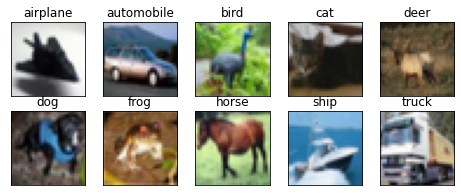

In [4]:
class_names =['airplane', 'automobile', 'bird','cat', 'deer', 'dog','frog', 'horse', 'ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes=10
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label==i)
    plt.imshow(img)

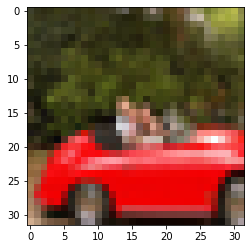

In [5]:
img, label = cifar10[99]
img, label, class_names[label]
plt.imshow(img)

In [6]:
dir(transforms)
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [7]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
img_t,_ = tensor_cifar10[99]
print(type(img_t))
print(img_t.shape, img_t.dtype)
print(img_t.min(), img_t.max())

<class 'torch.Tensor'>
torch.Size([3, 32, 32]) torch.float32
tensor(0.) tensor(1.)


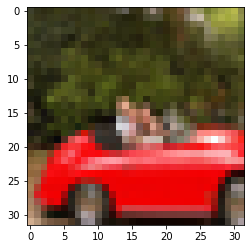

In [8]:
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [9]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [10]:
means=imgs.view(3,-1).mean(dim=1)
stds = imgs.view(3,-1).std(dim=1)
print(means, stds) 
print(transforms.Normalize(means, stds))

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])
Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))


In [11]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470,0.2435, 0.2616))])
)
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470,0.2435, 0.2616))])
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


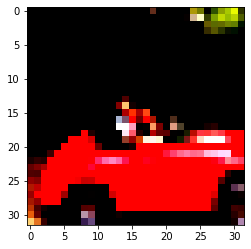

In [12]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [13]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0,2]]

In [14]:
n_out =2
model = nn.Sequential(nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512,n_out), nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


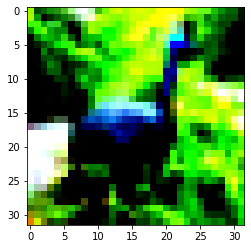

In [15]:
img, _ = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()


In [16]:
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out

tensor([[0.4239, 0.5761]], grad_fn=<SoftmaxBackward0>)

In [17]:
model = nn.Sequential(
    nn.Linear(3072, 512), 
    nn.Tanh(), 
    nn.Linear(512,2), 
    nn.LogSoftmax(dim=1)
)
loss = nn.NLLLoss()
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.8440, grad_fn=<NllLossBackward0>)

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [19]:

model = nn.Sequential(
    nn.Linear(3072, 512), 
    nn.Tanh(), 
    nn.Linear(512,2), 
    nn.LogSoftmax(dim=1)
)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.NLLLoss()
n_epochs =100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch<=2 or epoch%500==0):
        print(f"Epoch: {epoch} Loss {float(loss)}")
    



Epoch: 0 Loss 0.6201544404029846
Epoch: 1 Loss 0.7478348612785339
Epoch: 2 Loss 0.6066755056381226


KeyboardInterrupt: 

In [25]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)
correct=0
total=0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(outputs,dim=1)
        total+= labels.shape[0]
        correct+= int((predicted == labels).sum())
    print("Accuracy: %f"%(correct/total))

[(tensor([[[ 0.4710,  0.6615,  ...,  1.2172,  1.0585],
         [ 0.4393,  0.5980,  ...,  1.2331,  1.0108],
         ...,
         [-0.5768, -1.0373,  ..., -1.0214, -0.7991],
         [-0.5292, -1.0373,  ..., -0.9738, -0.8309]],

        [[ 0.5317,  0.8538,  ...,  1.2725,  0.9665],
         [ 0.5156,  0.9021,  ...,  1.4819,  1.0793],
         ...,
         [-0.6601, -1.0466,  ..., -0.9500, -0.8695],
         [-0.7245, -1.1432,  ..., -0.9339, -0.8856]],

        [[ 0.5257,  1.0953,  ...,  1.4701,  0.8555],
         [ 0.6456,  1.3502,  ...,  1.6949,  1.0353],
         ...,
         [-0.7785, -0.9134,  ..., -0.8985, -0.9434],
         [-0.7485, -0.9434,  ..., -0.9284, -0.9584]]]), 0), (tensor([[[-0.5610, -0.5610,  ..., -0.4022, -0.4022],
         [-0.5292, -0.5133,  ..., -0.3546, -0.3704],
         ...,
         [-0.4022, -0.3863,  ..., -0.5610, -0.5610],
         [-0.4181, -0.4022,  ..., -0.5610, -0.5768]],

        [[ 0.0163,  0.0163,  ...,  0.0807,  0.0968],
         [ 0.0646,  0.0646,

In [21]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(), 
    nn.Linear(1024,512), 
    nn.Tanh(), 
    nn.Linear(512,128), 
    nn.Tanh(), 
    nn.Linear(128,2)
)
loss_fn = nn.CrossEntropyLoss()

In [22]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(), 
    nn.Linear(1024,512), 
    nn.Tanh(), 
    nn.Linear(512,128), 
    nn.Tanh(), 
    nn.Linear(128,2)
)
loss_fn = nn.CrossEntropyLoss()
n_epochs =100
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch<=2 or epoch%10==0):
        print(f"Epoch: {epoch} Loss {float(loss)}")

Epoch: 0 Loss 0.4137934148311615


KeyboardInterrupt: 

In [24]:
correct=0
total=0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0],-1))
        _,predicted = torch.max(outputs,dim=1)
        print(predicted)
        print(labels)
        total+= labels.shape[0]
        correct+= int((predicted == labels).sum())
        break
    print("Accuracy: %f"%(correct/total))

tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])
Accuracy: 0.828125
